In [1]:
# dir utility
from pathlib import Path
import os
# ds utility
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# ds modelling
import sklearn

import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000
pd.set_option('display.max_columns', None)

In [2]:
# directory setup
ROOT = Path(os.getcwd())
DATA_DIR = ROOT / "input"
display(ROOT, DATA_DIR)
os.listdir(DATA_DIR)

WindowsPath('C:/Users/hlao1/Github/kaggle-titanic')

WindowsPath('C:/Users/hlao1/Github/kaggle-titanic/input')

['gender_submission.csv', 'test.csv', 'train.csv']

# Exploratory Data Analysis

In [64]:
# Load datasets
train = pd.read_csv(DATA_DIR/"train.csv")
test = pd.read_csv(DATA_DIR/"test.csv")
# surface level inspection of the training data loaded
display(train.head())
# display general info about the dataset
display(train.info())
# observe general stats of feat-cols 
display(train.describe())

feat_cols = train.columns.to_list()
display(feat_cols)
print("Number of features:",len(feat_cols))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

Number of features: 12


In [4]:
# remove passengerId which is simply used for maintaining training instance indices ie an non impactful column in terms of the classificaiton problem
train = train.drop(labels="PassengerId",axis=1)
# 
feat_cols = train.columns.to_list()
display(feat_cols)
print("Number of features:",len(feat_cols))

['Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

Number of features: 11


In [5]:
sample_submission = pd.read_csv(DATA_DIR / "gender_submission.csv")
sample_submission.head() # classification problem of predicting the target feat-col: "survived"

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# Data Description
| Variable | Definition | Key |
|----------|-----------|------|
|survival	|Survival|	0 = No, 1 = Yes|
|pclass	|Ticket class|	1 = 1st, 2 = 2nd, 3 = 3rd|
|sex	|Sex	||
|Age|	Age in years	||
|sibsp|	# of siblings / spouses aboard the Titanic	||
|parch	|# of parents / children aboard the Titanic	||
|ticket	|Ticket number	||
|fare|	Passenger fare	||
|cabin|	Cabin number	||
|embarked|	Port of Embarkation	|C = Cherbourg, Q = Queenstown, S = Southampton|

# Variable Notes
pclass: A proxy for socio-economic status (SES)<br>
1st = Upper <br>
2nd = Middle<br>
3rd = Lower<br>

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5<br>

sibsp: The dataset defines family relations in this way...<br>
Sibling = brother, sister, stepbrother, stepsister<br>
Spouse = husband, wife (mistresses and fiancés were ignored)<br>

parch: The dataset defines family relations in this way...<br>
Parent = mother, father<br>
Child = daughter, son, stepdaughter, stepson<br>
Some children travelled only with a nanny, therefore parch=0 for them.<br>


# Initial Thoughts on Plan of Action
Objective: Predict the target variable "survived" using the classification problem's data set "train.csv" provided.
1. Inspect in further detail of the given features via plots
2. Evaluate methods of plotting and select appropriate method for the data type
3. Look out for anomalies such as: non-Gaussian distros, outliers
4. Observe variables' dependencies/relations using covar matrix -- a "heat map"
5. Understand data types to be worked with

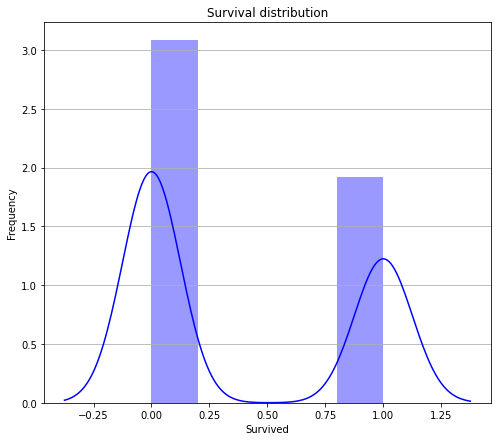

Skewness: 0.478523
Kurtosis: -1.775005


In [63]:
# attempt to plot target variable
f, ax = plt.subplots(figsize=(8, 7))
sns.distplot(train['Survived'], color="b");
ax.set(ylabel="Frequency")
ax.set(xlabel="Survived")
ax.set(title="Survival distribution")
# sns.despine(trim=True, left=True)
plt.grid(True)
ax.xaxis.grid(False)

plt.show()
print("Skewness: %f" % train['Survived'].skew())
print("Kurtosis: %f" % train['Survived'].kurt())

The chosen distribution plot method does not appear to display the data in a manner that is meaningful -- perhaps there isn't much to be drawn from the individual target variable itself outside of the fact that more people died than those that survived. Alternative plot methods could be either a scatter plot or a box plot. The double distribution curves are expected given the discrete nature of the variable ( 0 or 1 ie dead or alive)

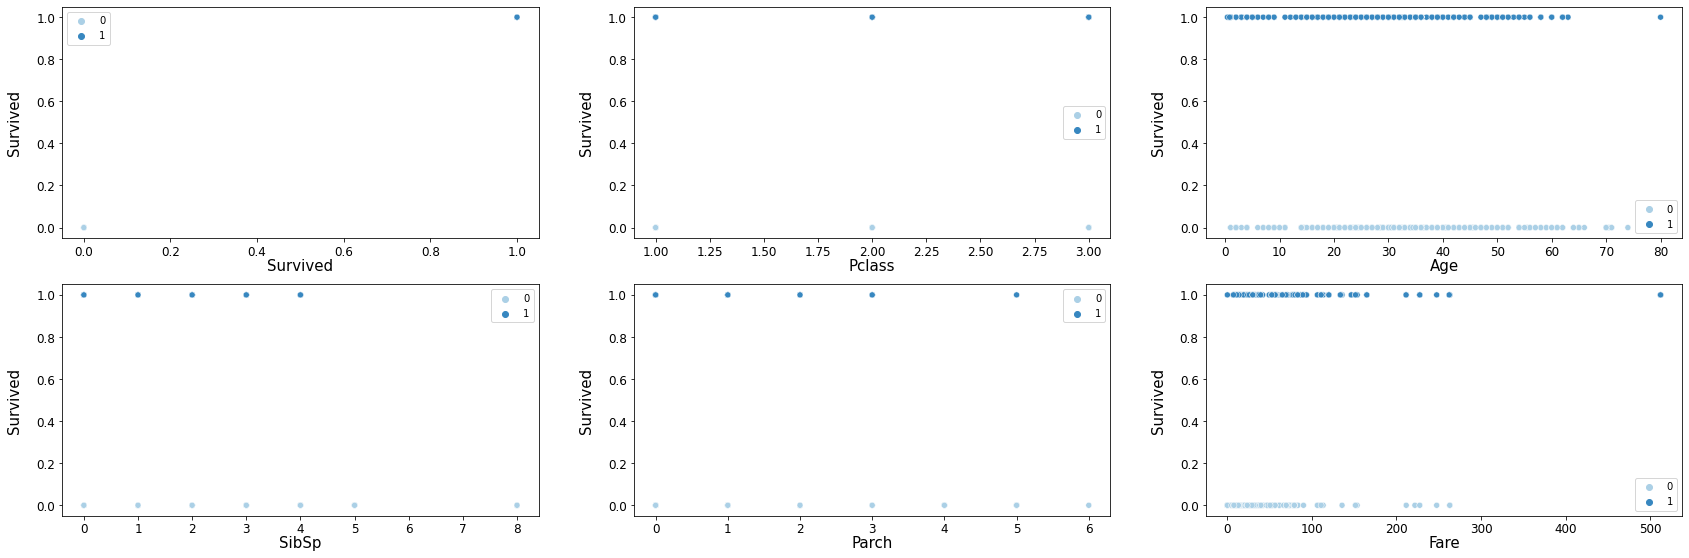

In [7]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric = []
for i in train.columns:
    if train[i].dtype in numeric_dtypes:
#         if i in ['TotalSF', 'Total_Bathrooms','Total_porch_sf','haspool','hasgarage','hasbsmt','hasfireplace']:
#             pass
#         else:
        numeric.append(i)     

# visualising some more outliers in the data values
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12,12))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)
for i, feature in enumerate(list(train[numeric]), 1):
    plt.subplot(len(list(numeric)), 3, i)
    sns.scatterplot(x=feature, y='Survived', hue='Survived', palette='Blues', data=train)
    plt.xlabel('{}'.format(feature), size=15,labelpad=0)
    plt.ylabel('Survived', size=15, labelpad=14)
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    plt.legend(loc='best', prop={'size': 10})
plt.show()


Not sure what conclusions I can draw given these plots. Perhaps a boxplot

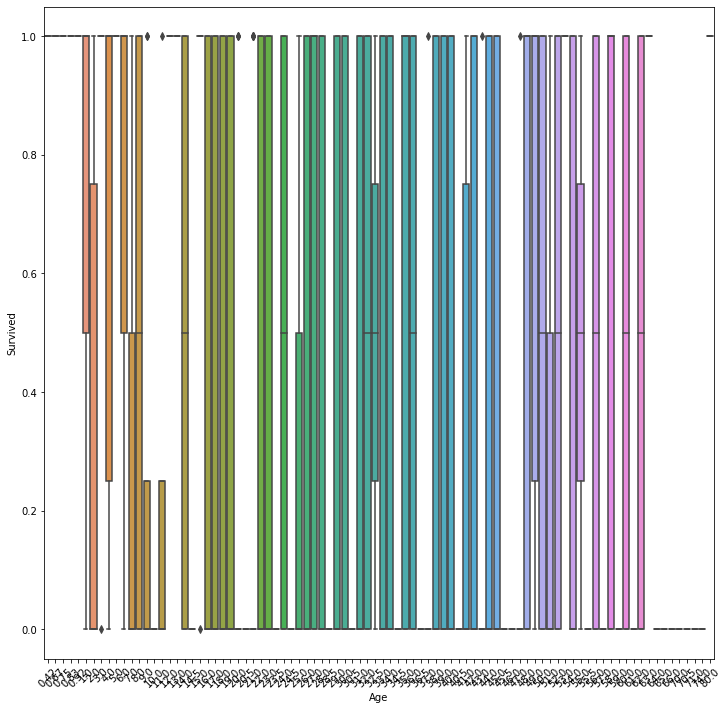

In [8]:
data = pd.concat([train['Survived'], train['Age']], axis=1)
f, ax = plt.subplots(figsize=(12,12))
fig = sns.boxplot(x=train['Age'], y="Survived", data=data)
plt.xticks(rotation=45)
# fig.axis(ymin=train['Survived'].min(), ymax=train['Survived'].max());
plt.show()


Still uncertain about what to make of the data. The rationale for plotting these particular features were based upon a linear regression problem in which numeric datatypes were plotted. In this particular case, it's clear that plotting numerics against a label does not show all too much. Perhaps a distribution plot applied to all features would be more useful?

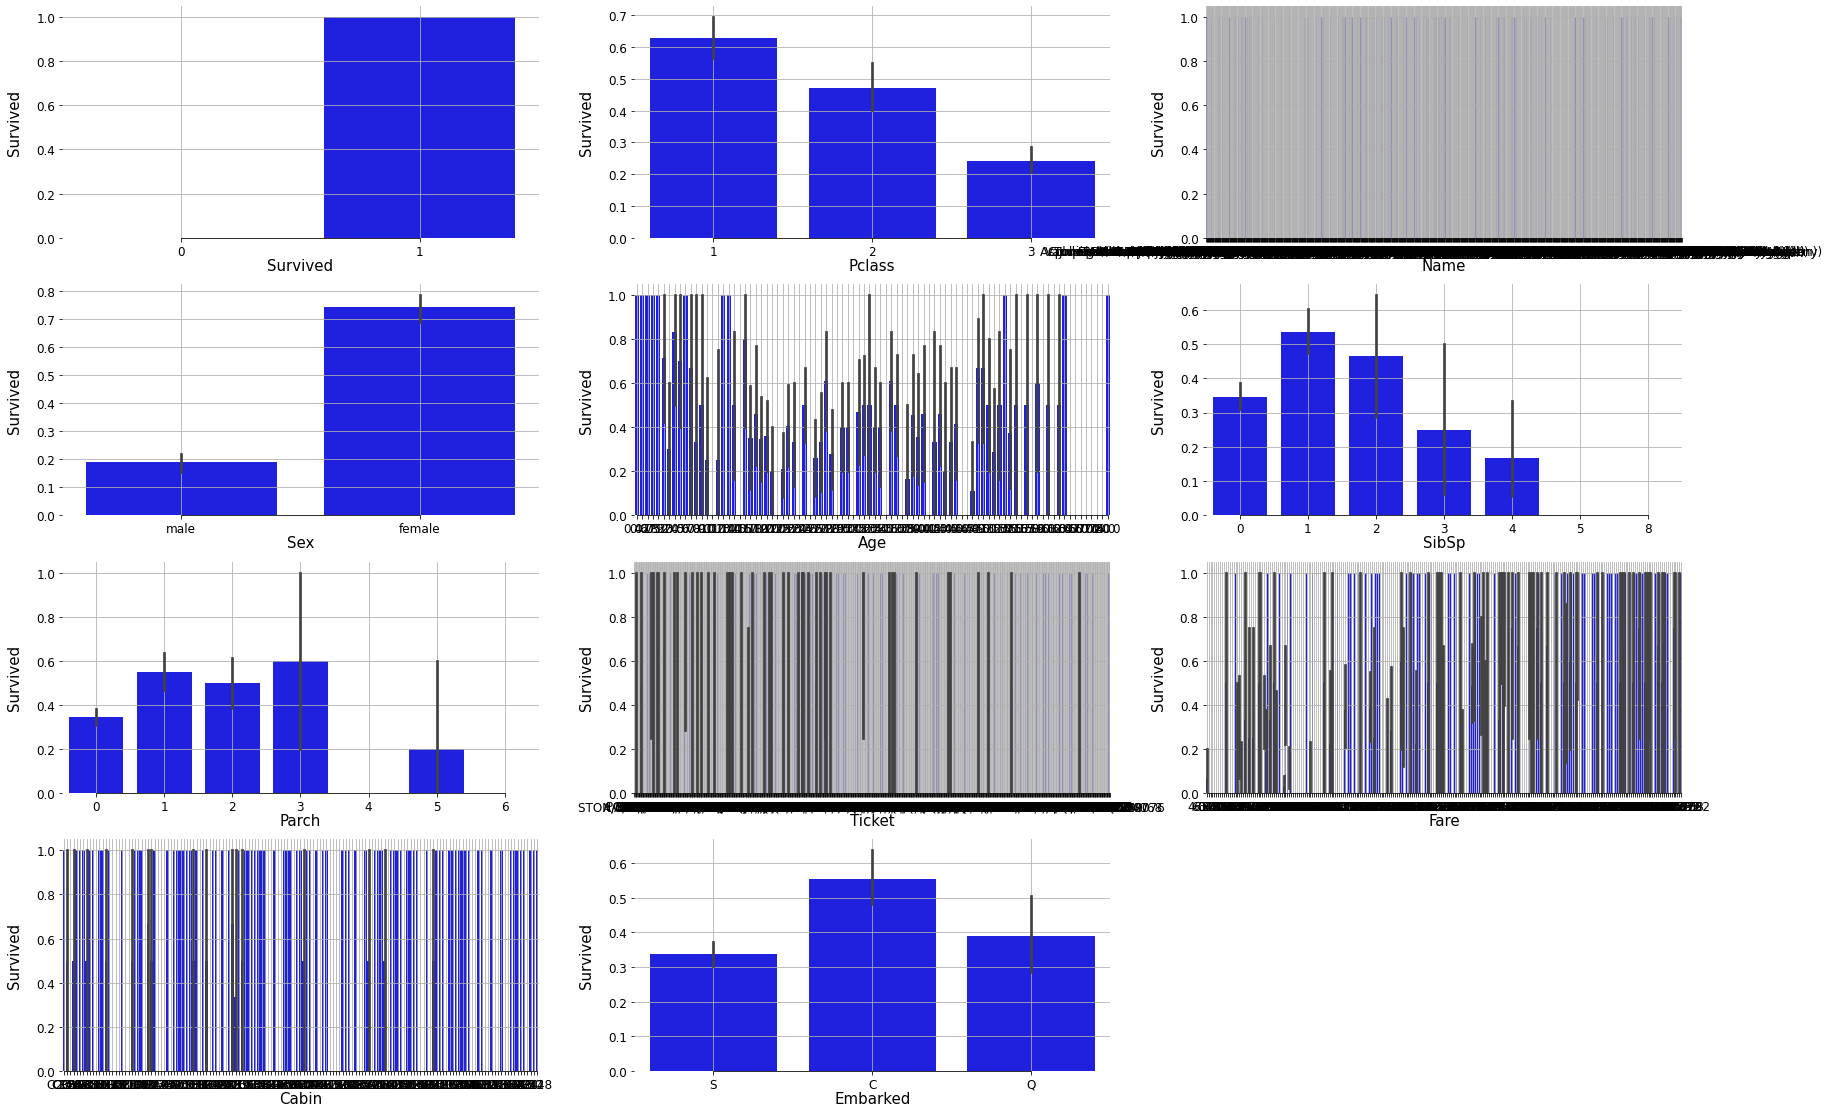

In [9]:

# visualising some more outliers in the data values
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12,12))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)
for i, feature in enumerate(list(train[feat_cols]), 1):
    plt.subplot(len(list(numeric)), 3, i)
    sns.barplot( train[feature],train['Survived'], color="b");
    sns.despine(trim=True, left=True)
    plt.grid(True)
    plt.xlabel('{}'.format(feature), size=15,labelpad=0)
    plt.ylabel('Survived', size=15, labelpad=14)
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
#     plt.legend(loc='best', prop={'size': 10})
plt.show()


# Feature vs Target Feature Analysis
* pclass vs survived
    * there appears to be a relation between passenger socioeconomic class and their rate of survival
    * upper-class passengers are more inclined to survive in contrast to lower-class passengers
* sex vs survived
    * women were far more likely to survive in contrast to males
* age vs survived
    * there appears to be a bit of a relation; however, requires further investigation
* siblings & spouses VS surived
    * passengers who had a larger party (spouses or siblings) were less inclined to survive
    * the cut off point appears to be at 2 siblings & spouses at which there appears to be a large drop off in the survival rate
* parch (# parents/children) vs survived:
    * no parent or child case appears to potentially be an outlier -- not sure about the reasonings as to why
    * the case of 1/2/3 parch sizes appear to make sense in terms of the survival rate of the passenger
    * not sure what to make meaining behind the portruding line drawn
* ticket number & survived:
    * there may be some information here in regards to how passengers were seated upon the ship; however, given the uniqueness of ticker numbers there cannot be any direct conclusions made about the relation between a passengers ticket nubmer and their survival rate
* fare vs survived
    * there is likely a relation here based upon the observations of pclass vs survival rate
    * a closer inspection is needed
* cabin vs survived
    * it is possible that there may be some correlation between survival rate given a passengers cabin number
    * this correlation is motivated by an understanidng of how ships hold multiple levels of cabins thus, the passengers at the lowest level cabins would likely not have been able to make it to the rafts sooner than the ones at the upper level
    * cabin and pclass may share a relation
    * cabin and fare may share a relation
* embarked vs survived
    * naturally inclined to think that the port of embarkation is likely to have little to no relation with survival rate
    * a case for a relation to exist would be that the location may represent a culture of alertness to dangers suggesting a better prepared passenger for moments of danger
    * what is the significance of the location of embarkation?
    * what is the reason for passengers who embarked at Cherbourg having a higher survival chance?
* survived vs survived
    * NA
* name vs survived
    * NA

<AxesSubplot:>

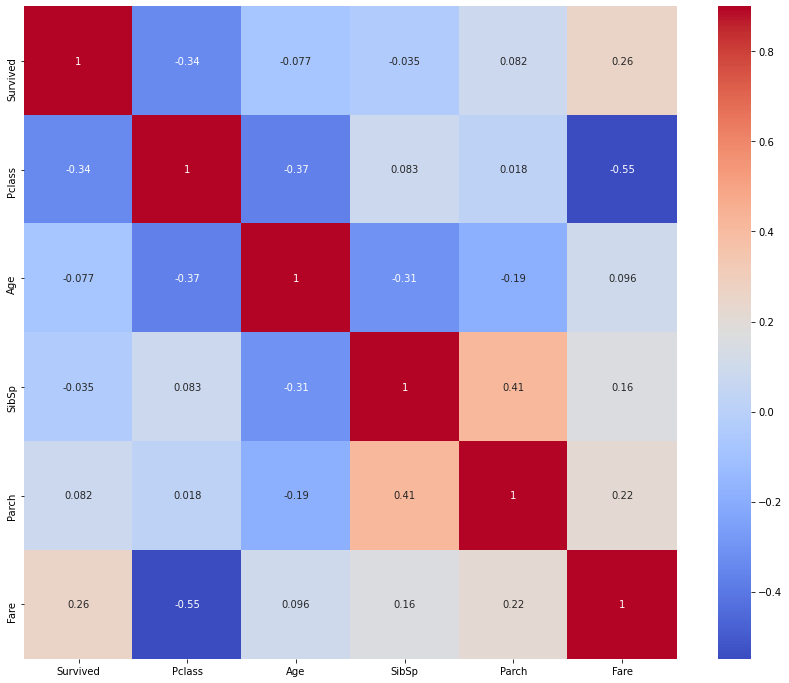

In [58]:
corr = train.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmax=0.9, cmap="coolwarm", square=True, annot= True)


# Feature Imputation
Does there exist any missing values? How many? How do we appropriately fill in for these missing values?

In [54]:
# Missing Features in Training Dataset
all_cols = train.isna().any()
na_cols = [c for c in all_cols.index if all_cols[c] == True]
display("All columns:",train.isna().any(), "Missing cols:", na_cols)
print()
for c in na_cols:
    na_count = train[c].isna().sum()
    total = len(train[c])
    na_percent =  na_count / total * 100
    print(c, "feature instances missing: {:1.5f}%".format(na_percent))

'All columns:'

Survived    False
Pclass      False
Name        False
Sex         False
Age          True
SibSp       False
Parch       False
Ticket      False
Fare        False
Cabin        True
Embarked     True
dtype: bool

'Missing cols:'

['Age', 'Cabin', 'Embarked']


Age feature instances missing: 19.86532%
Cabin feature instances missing: 77.10438%
Embarked feature instances missing: 0.22447%


How do we go about feature imputation?'
* currently only observing just the training instances, need to impute for the set of ALL instances ie train + test dataset
* based upon the data description how would we create new features? consider 1 or more variables from which we can define a new feature>
    - for example: denoting whether the passenger is travelling alone or not
* apply KNN algorithm?


# Random Ideas
* Would we ever use PCA here? 
    - Considering that the dataset is extremely small in terms of the degree of dimnesions, there would be very little reason for applying a technique to reduce dimensionality
    - PCA may actually hurt the performance of the model
    - Worth exploring to provide concreteness/assessing these claims

# References for New Ideas/Perspectives
* <b>Python DS Framework</b>: https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy
    * <b.Notable sections:</b>
        - Problem Definition
        - Data Preparation
        - Meet & Greet the Data (EDA)
    * <b>My Takeaways & Reflection from Reading</b>
        - Nearly all of my intuitons & observations up to this point of the jupyter notebook were on-point with the notes defined in the "Meet & Greet the Data" section
        - Good Practice? make a copy rather of the data rather than altering it directly?
        - <b>4Cs of Data Cleaning</b>
            1. Correcting: adjust outlier values
            2. Completing: feature imputation ie filling in the non-existing values
            3. Creating: feature engineering ie utilize existing features to create new ones
            4. Converting: convert to dummy variables ie hot encode (Ex. conversion using a kv-mapping of strings to integer vals)?
        - Performing feature imputation: usage of median & mode
            - why median over average for "Age" & "Fare"? 
            - why mode for "Embarked"?
            - could we utilize the set of all instances that do not have missing columns from which we train a model to predict for the instances that contain missing values?
        - Performing feature engineering
            - Why do we use pd.qcut? What does it do? What was the rationale for qcutting for the features denoted in the notebook?
* <b>Python Ensemble Methods</b>: https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling
    * <b>Notable Sections:</b>
        - Outlier Detection (Tukey Method)
    * <b>My Takeaways & Reflection from Reading</b>
        - Revealed my own weakness -- a need deepen my stats understaning in terms of the significance of outliers 
        - A need to understand methods of cleaning out data ie removal of outliers (what other forms exist outside of the Tukey method provided?)
            - Other outlier detection methods: https://towardsdatascience.com/practical-guide-to-outlier-detection-methods-6b9f947a161e
        - Usage of a FacetGrid from Seaborn in displaying age distribution and surival outcome
        - Usage of a kdeplot for overlaying the two plots pertaining to 2 survival outcomes on one chart
        - Approaching each datatype with the appropriate plotting method is so important
* <b>R Tutorial</b>: https://www.kaggle.com/mrisdal/exploring-survival-on-the-titanic
    * Organized very well
    * Provides alot of useful commentary for gaining insight into the steps taken

In [ ]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])